In [1]:
import cv2
import os
import imutils
import numpy as np

import json
import random
from time import sleep

In [2]:
from IPython.display import clear_output
from google.colab.patches import cv2_imshow 
import matplotlib.pyplot as plt

In [3]:
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [4]:
import pandas as pd

In [5]:
%matplotlib inline

In [6]:
base_colab = 'drive/MyDrive/'

In [7]:
DATA_CONFIG = [
    {
        "ubiris_url" : 'drive/MyDrive/ubirisv2/CLASSES_400_300_Part1/',
        "dataset_url": "drive/MyDrive/datasets/cut_eyes/",
        "total_people": 260,
        "allowed_img_ids": [13, 14, 15],
        "allowed_session_ids": [1],
        "excluded_pepople": [53,54,55,56]
    },
    {
        "ubiris_url" : 'drive/MyDrive/ubirisv2/CLASSES_400_300_Part2/',
        "dataset_url": "drive/MyDrive/datasets/cut_eyes/",
        "allowed_img_ids": [13, 14, 15],
        "allowed_session_ids": [1],
        "excluded_pepople": [53,54,55,56]
    }
]

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#@title
def canny_edge_detect(image, min = 60, max=120):
  #Detecção de bordas por Canny
  _image = apply_blur_on_image(image)
  canny=cv2.Canny(_image, min, max)
  #canny=cv2.Canny(gray, 170, 200)
  #plt.imshow(canny,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
  return canny

In [10]:
#@title
def apply_contourns(image, canny):
  edges, _ = cv2.findContours(canny.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  draw = cv2.drawContours(image.copy(), edges, -1, (255,255,255), 2)
  #plt.imshow(draw,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
  return draw

In [11]:
#@title
def create_euclidean_array(circles,x_center,y_center):
  distances = []
  #print("Image center: {}".format((x_center,y_center)))
  for circle in circles:
    #x,y = circle[0],circle[1]
    point1 = np.array((circle[0],circle[1]))
    point2 = np.array((x_center,y_center))
    
    distances.append(np.linalg.norm(point1-point2))
  return distances

In [12]:
#@title
def select_circle(circles,x_center,y_center,neighbors=3):
  _distances = []
  distances = []
  #print("Image center: {}".format((x_center,y_center)))
  _distances = create_euclidean_array(circles,x_center,y_center)
  
  indices = sorted(
    range(len(_distances)),
    key=lambda index: _distances[index]
  )
  #indices.sort(reverse=True)
  #print("best distances static center: {} {} {}".format(_distances[indices[0]], _distances[indices[1]],_distances[indices[2]] ))
  selected_circles = []
  x, y = 0 , 0
  max_circles = neighbors if len(circles) > neighbors else len(circles)
  for i in range(max_circles):
    selected_circles.append(circles[indices[i]])
    x += circles[i][0]
    y += circles[i][1]
  factor = 1 #random.uniform(0, 0.5)
  x_adjusted = int((x/max_circles - x_center) * factor + x_center)
  y_adjusted = int((y/max_circles - y_center)  + y_center)
  #print("Image center adjusted: {}".format((x,y)))
  

  distances = create_euclidean_array(circles, x_adjusted, y_adjusted)

  #print("fixed {} - adjusted {}".format(min(_distances),min(distances)))
  if (min(_distances) > min(distances)):
    mindist = min(distances)
    minpos = distances.index(mindist)
  else:
    mindist = min(_distances)
    minpos = _distances.index(mindist)
  mindist = min(distances)
  minpos = distances.index(mindist)
  return (circles[minpos], mindist)

In [13]:
def find_best_circle(draw, print_output=False, output_image= None, show_circles=False):
  _draw = draw.copy()
  #houg_settings=[[70,80],[80,90]]
  houg_settings=[[70,80],[80,90],[90,100]]
  #houg_settings=[[70,80],[80,90],[90,100], [100,110]]
  #houg_settings=[[85,100]]
  (x, y, _) = draw.shape

  center_mask = np.zeros((x,y),np.uint8)
  cv2.circle(center_mask, (int(y/2), int(x/2)), int(y/2), (255, 255, 225), -1)
  _draw = apply_mask(center_mask,_draw)

  gray = cv2.cvtColor(_draw, cv2.COLOR_BGR2GRAY)


  gray_img_blur = cv2.medianBlur(gray, 5)
  
  '''

  kernel = np.ones((5,5),np.uint8)
  
  #Morphological Transformations
  
  gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_OPEN, kernel)
  print_image(gray_img_blur)
  gray_img_blur = cv2.erode(gray_img_blur,kernel,iterations  = 1)
  print_image(gray_img_blur)
  gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_OPEN, kernel)
  print_image(gray_img_blur)
  gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_GRADIENT, kernel)
  '''
  #gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_GRADIENT, kernel)
  #gray_img_blur = cv2.erode(gray_img_blur,kernel,iterations  = 1)
  #gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_TOPHAT, kernel)
  #gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_CLOSE, kernel)
  #gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_OPEN, kernel)

  #cimg = cv2.cvtColor(gray_img_blur, cv2.COLOR_GRAY2BGR)
  best_circle = None
  best_dist = None
  best_ray = None
  
  print_image(gray_img_blur)
  best_settings = None
  for settings in houg_settings:
    print("current houg settings: {}".format(settings))
    circles = cv2.HoughCircles(gray_img_blur, cv2.HOUGH_GRADIENT, 1, gray.shape[0]/64, param1=1110, param2=11, minRadius=settings[0], maxRadius=settings[1])
    
    if show_circles and circles is not None and output_image is not None:
      circles = np.uint16(np.around(circles))
      img_circles = output_image.copy()
      for i in circles[0, :]:
          # Draw outer circle
          cv2.circle(img_circles, (i[0], i[1]), i[2], (0, 255, 0), 2)
          # Draw inner circle
          cv2.circle(img_circles, (i[0], i[1]), 2, (0, 0, 255), 3)
      print_image(img_circles)
      del(img_circles)
    
    circle, dist = None, None
    #if circles is not None and len(circles[0]) > 1 :
    if circles is not None:
      print("have circles")
      circle, dist = select_circle(circles[0], int(y/2) ,int(x/2))
      if circle is not None:
        best_circle = circle
        best_dist = dist
        best_ray = circle[2]
      if best_circle is None:
        best_circle = circle
        best_dist = dist
        best_ray = circle[2]
    


    if circle is not None:
      if dist < best_dist: #and best_ray < circle[2]:
      #if dist < best_dist and best_ray < circle[2]:
        best_settings = settings
        best_dist = dist
        best_circle = circle
        best_ray = circle[2]

  if best_circle is None:
    print("Not circles found")
    return None

  best_circle = np.uint16(np.around(best_circle))
  print("houg settings: {} with ray: {}".format(best_settings, best_circle[2]))
  print("best cicle found: ({},{})".format(best_circle[0], best_circle[1]))

  mask = np.zeros((x,y),np.uint8)
  cv2.circle(mask, (best_circle[0], best_circle[1]), best_circle[2], (255, 255, 225), -1)
  if output_image is not None:
    border_iris = output_image.copy()
    cv2.circle(border_iris, (best_circle[0], best_circle[1]), best_circle[2], (255, 255, 225), 2)
    cv2.circle(border_iris, (best_circle[0], best_circle[1]), 2, (0, 0, 255), 3)
    #plt.imshow(border_iris,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
    #plt.show()
    print_image(border_iris)
  return mask

In [14]:
#@title
def apply_mask(mask,image):
  masked = cv2.bitwise_and(image, image, mask=mask)
  return masked

In [15]:
#@title
def detect_best_circle_in(image,canny_config=(60,80),show_circles=False):
  #_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  _image = image.copy()
  #_canny = canny_edge_detect(image, 60, 120)
  _canny = canny_edge_detect(image, canny_config[0],canny_config[1])
  print_image(_canny)
  _image = apply_contourns(_image, _canny)
  mask = find_best_circle(_image, output_image = image.copy(),print_output=True,show_circles=show_circles)
  if mask is None:
    return image
  iris_rounded = apply_mask(mask,image.copy())
  print_image(iris_rounded)
  return iris_rounded
  

In [16]:
#@title
def save_image(directory,filename,image):
  print(directory + filename)
  if not os.path.exists(directory):
    os.makedirs(directory)
  cv2.imwrite(str(directory + filename), image)

In [17]:
#@title
def apply_blur_on_image(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray_img_blur = cv2.medianBlur(gray, 5)

  kernel = np.ones((5,5),np.uint8)
  
  #Morphological Transformations

  gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_OPEN, kernel)
  gray_img_blur = cv2.erode(gray_img_blur,kernel,iterations  = 1)
  gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_OPEN, kernel)
  return gray_img_blur


In [18]:
#@title
def print_image(image):
  plt.imshow(image,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
  plt.show()

In [19]:
#@title
def extract_info(file_name):
  file_name = file_name.split('.')[0]
  [user, session, image] = file_name.split('_')
  user_id = user.replace("C",'')
  session_id = session.replace("S",'')
  image_id = image.replace("I",'')
  return [user_id, session_id, image_id]

In [20]:
#@title
def get_all_ids():
  ids = []
  for folder in os.listdir("drive/MyDrive/datasets/base_eyes/"):
    user_id = int(folder.replace("C",""))
    if user_id in [53,54]:
      continue
    if user_id not in ids:
      #print(user_id)
      ids.append(user_id)
  
  return sorted(ids)

In [21]:
#@title
def approve_derectory():
  ids = []
  for folder in os.listdir("drive/MyDrive/datasets/cut_eyes/"):
    user_id = int(folder.replace("C",""))
    files = os.listdir("drive/MyDrive/datasets/cut_eyes/" + folder)
    if len(files) >= 3:
      #print(user_id)
      ids.append(user_id)
  
  return sorted(ids)  

In [ ]:
all_ids = get_all_ids()

In [ ]:
len(all_ids)

516

In [ ]:
ok_ids = approve_derectory()

In [22]:
#@title
DATA_CONFIG = [
    {
        "ubiris_url" : 'drive/MyDrive/ubirisv2/CLASSES_400_300_Part1/',
        "dataset_url": "drive/MyDrive/datasets/cut_eyes/",
        "total_people": 260,
        "allowed_img_ids": [13, 14, 15],
        "allowed_session_ids": [1],
        "excluded_pepople": [53,54,55,56]
    },
    {
        "ubiris_url" : 'drive/MyDrive/ubirisv2/CLASSES_400_300_Part2/',
        "dataset_url": "drive/MyDrive/datasets/cut_eyes/",
        "allowed_img_ids": [13, 14, 15],
        "allowed_session_ids": [1],
        "excluded_pepople": [53,54,55,56]
    }
]

In [ ]:
len(all_ids)

516

In [ ]:
all_ids

In [ ]:
for id in range(1,523,1):
  if id not in all_ids:
    print(id)

53
54
407
408
409
410


In [ ]:
#@title
def create_dataset():
  starts_in = 1
  rejected_eyes = 0
  removed_ids = [53,54]
  approved_ids = approve_derectory()
  
  total_eyes = len(all_ids) - len(removed_ids)
  
  base_eyes = "drive/MyDrive/datasets/base_eyes/"
  cut_eyes = "drive/MyDrive/datasets/cut_eyes/"
  for customer in all_ids:
    if customer < starts_in:
      continue
    if customer in removed_ids:
      continue
    if customer in approved_ids:
      continue
    #path = DATA_CONFIG[0]["dataset_url"] + "C{}/".format(customer) if customer <= 260 else DATA_CONFIG[1]["dataset_url"] + "C{}/".format(customer)


    #files = ['C{}_S1_I13.tiff'.format(customer), 'C{}_S2_I13.tiff'.format(customer)]
    files = os.listdir(base_eyes + "C{}".format(customer))
    
    #path = DATA_CONFIG[0]["dataset_url"] + "C{}/".format(customer)

    for picture in files:
      if os.path.exists(cut_eyes + "C{}".format(customer)):
        existent_files = os.listdir(cut_eyes + "C{}".format(customer))
        if picture in existent_files:
          continue

      print("Customer {}".format(customer))
      image_path = base_eyes + "C{}/".format(customer) + picture
      #image_path = image_path.replace("\\","/")
      print(image_path)
      original=cv2.imread(image_path)
      original=cv2.cvtColor(original, cv2.COLOR_RGB2BGR)

      iris= detect_best_circle_in(original, canny_config=(5,15))
      
      #plt.imshow(iris,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
      #plt.show()
      print("Folder: C{} file: {} customer {}".format(customer,picture,customer))
      choice = str(input("salvar ? y/n"))
      save = True if choice == "y" else False

      if save:
        save_image(cut_eyes + "C{}/".format(customer), picture,cv2.cvtColor(iris, cv2.COLOR_BGR2RGB))
      else:
        rejected_eyes += 1
      clear_output()

      
  print("Completed {:.2f}% restant: {}".format(100*(total_eyes - rejected_eyes)/total_eyes, rejected_eyes ))


In [ ]:
create_dataset()

Completed 99.61% restant: 2


In [ ]:
#@title
"C1C220"[1:].split("C")[0]

'1'

In [ ]:
#@title
os.listdir("{}".format(DATA_CONFIG["falsely_generate"]["dataset_url"]))  

In [ ]:
#@title
target = 3
for comb in ["C1C2","C3C4","C5C1","C7C4"]:
  ids = comb[1:].split("C")
  print(ids)
  if str(target) == ids[0]:
    print([int(ids[0]), int(ids[1])])
    print("achei")
    break


In [ ]:
#@title
def verify_data_integrity(label_path):
  if label_path == "falsely":
    combinations = os.listdir(DATA_CONFIG["falsely_generate"]["dataset_url"])
    issues = []
    print(len(combinations))
    for combination in combinations:
      target = combination[1:].split("C")
      for comb in combinations:
        ids = combination[1:].split("C")
        #print("{} {} {} {}".format(target[0] , ids[0] , target[1],ids[1]))
        if target[0] == ids[1] and target[1] == ids[0]:
          issues.append(combination)
    print(issues)
    issues = []
    
    for combination in combinations:
      files = os.listdir(DATA_CONFIG["falsely_generate"]["dataset_url"] + "{}".format(combination))
      if len(files) < 2:
        print(files)
        issues.append(combination)
    print(issues)

In [ ]:
#@title

img = cv2.imread("drive/MyDrive/ubirisv2/CLASSES_400_300_Part1/C256_S1_I13.tiff")
a = apply_blur_on_image(img)
print_image(a)

In [ ]:
#@title
img = cv2.imread("drive/MyDrive/ubirisv2/CLASSES_400_300_Part1/C256_S1_I13.tiff")
print_image(img)
im = detect_best_circle_in(img, canny_config=(10,20))
print_image(im)

In [ ]:
#@title
create_dataset()

In [ ]:
#@title
img = cv2.imread("drive/MyDrive/ubirisv2/CLASSES_400_300_Part2/C430_S1_I13.tiff")
imgv2_2_work=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
detect_best_circle_in(imgv2_2_work)

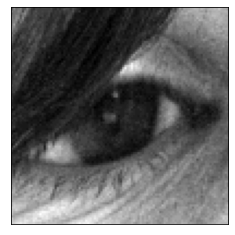

(100, 100)


In [ ]:
filename = "drive/MyDrive/ubirisv2/CLASSES_400_300_Part1/C243_S1_I15.tiff"
#image = cv2.imread(filename)
image = cv2.resize(image, (100,100), interpolation = cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
print_image(image)
print(image.shape)

In [ ]:
img = cv2.imread("drive/MyDrive/ubirisv2/CLASSES_400_300_Part2/C263_S1_I15.tiff")
img_2_work=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
canny = canny_edge_detect(img_2_work, 5,15)
print_image(canny)
img_2_work = apply_contourns(img_2_work, canny)
mask = find_best_circle(img_2_work, output_image = img.copy(),print_output=True, show_circles=True)
iris_rounded = apply_mask(mask,img_2_work.copy())
print("target image above")
#print_image(iris_rounded)

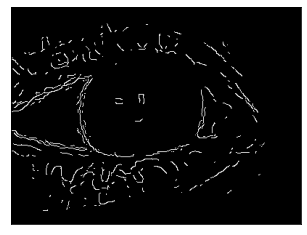

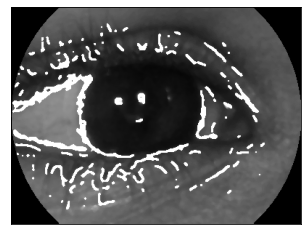

current houg settings: [70, 80]
current houg settings: [80, 90]
have circles
current houg settings: [90, 100]
houg settings: None with ray: 85
best cicle found: (178,134)


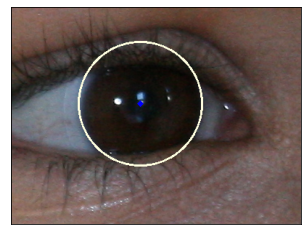

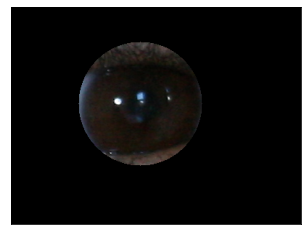

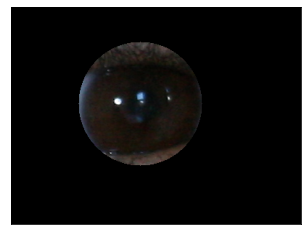

KeyboardInterrupt: ignored

In [24]:
picture = "C283_S1_I15.tiff"
image_path = "drive/MyDrive/ubirisv2/CLASSES_400_300_Part2/" + picture
cut_eyes = "drive/MyDrive/datasets/cut_eyes/"

original = cv2.imread(image_path)
original =cv2.cvtColor(original, cv2.COLOR_RGB2BGR)
iris = detect_best_circle_in(original, canny_config=(40,45))
print_image(iris)
save = input("Save? y/n: ")
if save:
  #save_image(cut_eyes + "C{}/".format(263), picture,cv2.cvtColor(iris, cv2.COLOR_BGR2RGB))
  pass

In [ ]:
def export_csv(merge_eyes=False):
  k = range(1, int(524/2), 1)
  cut_eyes = "drive/MyDrive/datasets/cut_eyes/"
  datasets_path = "drive/MyDrive/datasets/"
  person_path = []
  data = {
      "image_path": [],
      "class": []
  }
  filename = ""
  if merge_eyes:
    filename = "cut_eyes_merged.csv"
    pass
  else:
    folders = os.listdir(cut_eyes)
    filename = "cut_eyes.csv"
    #folders.sort()
    for folder in folders:
      id = int(folder.replace("C",""))
      pictures = os.listdir(cut_eyes + folder)
      for picture in pictures:
        picture_path = cut_eyes + folder + "/" + picture
        data["image_path"].append(picture_path)
        data["class"].append(folder)
      
      #print(id)
  df = pd.DataFrame.from_dict(data)
  print(datasets_path + filename)
  df.to_csv(datasets_path + filename)

  return pd.DataFrame.from_dict(data)

In [ ]:
export_csv()

drive/MyDrive/datasets/cut_eyes.csv


,image_path,class
0,drive/MyDrive/datasets/cut_eyes/C105/C105_S1_I...,C105
1,drive/MyDrive/datasets/cut_eyes/C105/C105_S2_I...,C105
2,drive/MyDrive/datasets/cut_eyes/C105/C105_S2_I...,C105
3,drive/MyDrive/datasets/cut_eyes/C105/C105_S2_I...,C105
4,drive/MyDrive/datasets/cut_eyes/C105/C105_S1_I...,C105
...,...,...
1938,drive/MyDrive/datasets/cut_eyes/C99/C99_S1_I15...,C99
1939,drive/MyDrive/datasets/cut_eyes/C99/C99_S2_I14...,C99
1940,drive/MyDrive/datasets/cut_eyes/C449/C449_S2_I...,C449
1941,drive/MyDrive/datasets/cut_eyes/C449/C449_S2_I...,C449
